# Introduction
Here I pseudobulk by cell type-condition so that we can run DESeq2 on the mRNA and ADTs.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce
import anndata

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=30

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

# Load in Data

In [6]:
path = prefix_comb + 'h5ads/concat_5.h5ad'
concat = sc.read_h5ad(path)

# Get Raw Data

In [5]:
def get_raw_adts(obs_names):
    path = prefix + 'adts/pkls/concat.adts.pkl'
    
    with open(path,'rb') as file:
        return pkl.load(file)[obs_names, :]

def get_raw_mrna(obs_names):
    path = prefix + 'mrna/pkls/aggr/wells.sng.w_covars.pkl'
    
    with open(path,'rb') as file:
        wells = pkl.load(file)
    
    for well in wells:
        wells[well]['adata'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata'].obs_names]
    
    return wells[0]['adata'].concatenate(*[wells[i]['adata'] for  i in range(1, 12)])[obs_names,:]
    
def clr_normalize_column(x):
    normed_column = np.log1p((x) / (np.exp(sum(np.log1p((x)[x > 0 ])) / len(x + 1))))
    return normed_column

def clr_normalize(x):
    normed_matrix = np.apply_along_axis(clr_normalize_column, 1, x)
    return normed_matrix
    
def get_raw(adata, transformed=True):
    raw_mrna = get_raw_mrna(adata.obs_names)
    raw_adts = get_raw_adts(adata.obs_names)
    
    adata.obs['adts_n_counts'] = raw_adts.X.toarray().sum(axis=1)
    
    if transformed == True:
        sc.pp.normalize_per_cell(raw_mrna,counts_per_cell_after=1e6)
        sc.pp.log1p(raw_mrna)
        
        sc.pp.normalize_per_cell(raw_adts, counts_per_cell_after=1e6);
        raw_adts.X = clr_normalize(raw_adts.X.toarray())
    
    return raw_mrna, raw_adts

In [6]:
raw_mrna, raw_adts = get_raw(concat, transformed=False)

In [7]:
raw_mrna.obs['ct2'] = concat.obs['ct2']

Trying to set attribute `.obs` of view, copying.


In [8]:
conds = concat.obs['cond'].dtype.categories
clusts = concat.obs['ct2'].dtype.categories

In [9]:
cond_ct_df = pd.DataFrame(index=conds, columns=clusts, dtype=np.int)

In [10]:
for cond in tqdm(conds):
    for clust in clusts:
        cond_ct_df.loc[cond, clust] = concat[(concat.obs['cond'] == cond) & (concat.obs['ct2'] == clust)].shape[0]

After the last cell, ct2_colors disappears (haven't bothered to figure out why) but I'm just going to set it manually here.

In [11]:
ct2_colors = concat.uns['ct2_colors']

In [12]:
concat.uns['ct2_colors'] = ct2_colors

In [13]:
cond_ct_df_div = cond_ct_df.divide(cond_ct_df.sum(0),1)

In [14]:
high_count_cts = concat.obs['ct2'].value_counts()[:-2].index.tolist()
print(high_count_cts)

['T4_Naive', 'T4_Mem', 'cM', 'T8_Naive', 'T_Tox', 'B_Naive', 'NK', 'B_Mem', 'cDC', 'ncM', 'pDC', 'M_cDC_PMA/I', 'HSC']


In [15]:
free_ids = np.unique(concat.obs['free_id'].values)
ind_ct = pd.DataFrame(0, index=free_ids, columns=high_count_cts)

In [16]:
for free_id, ct in tqdm(it.product(free_ids, high_count_cts)):
    ind_ct.loc[free_id, ct] = len(concat.obs[(concat.obs['free_id'] == free_id) & (concat.obs['ct2'] == ct)])

In [17]:
ct_cond_id = list(it.product(high_count_cts, ['A', 'B', 'C', 'G', 'P', 'R'], free_ids))

In [18]:
ct_cond_id_df = pd.DataFrame(ct_cond_id, columns=['CT','COND', 'FID'])

In [19]:
ct_cond_id_df

,CT,COND,FID
0,T4_Naive,A,0
1,T4_Naive,A,1
2,T4_Naive,A,10
3,T4_Naive,A,11
4,T4_Naive,A,12
...,...,...,...
4987,HSC,R,62
4988,HSC,R,63
4989,HSC,R,7
4990,HSC,R,8


In [20]:
counts_genes = list()
cell_counts = list()
for ct, cond, free_id in tqdm(ct_cond_id):
    arr = raw_mrna[(raw_mrna.obs['ct2'] == ct) & (raw_mrna.obs['cond'] == cond) & (raw_mrna.obs['free_id'] == free_id)].X.toarray()
    cell_counts.append(len(arr))
    counts_genes.append(arr.sum(axis=0))

In [21]:
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(cell_counts),columns=['NUM_CELLS']))
ct_cond_id_df = ct_cond_id_df.join(pd.DataFrame(data=np.array(counts_genes),columns=raw_mrna.var_names))

In [22]:
lot = list()
for i in ct_cond_id_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

In [23]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'M_cDC_PMA/I-A', 'M_cDC_PMA/I-B', 'M_cDC_PMA/I-C', 'M_cDC_PMA/I-G',
        'M_cDC_PMA/I-P', 'M_cDC_PMA/I-R', 'NK-A', 'NK-B', 'NK-C', 'NK-G',
        'NK-P', 'NK-R', 'T4_Mem-A', 'T4_Mem-B', 'T4_Mem-C', 'T4_Mem-G',
        'T4_Mem-P', 'T4_Mem-R', 'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C',
        'T4_Naive-G', 'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A',
        'T8_Naive-B', 'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P',
        'T8_Naive-R', 'T_Tox-A', 'T_Tox-B', 'T_Tox-C', 'T_Tox-G',
        'T_Tox-P', 'T_Tox-R', 'cDC-A', 'cDC-B', 'cDC-C', 'cDC-G', 'cDC-P',
        'cDC-R', 'cM-A', 'cM-B', 'cM-C', 'cM-G', 'cM-P', 'cM-R', 'ncM-A',
        'ncM-B', 'ncM-C', 'ncM-G', 'ncM-P', 'ncM-R', 'pDC-A', 'pDC-B',
        'pDC-C', 'pDC-G', 'pDC-P', 'pDC-R'], dtype='<U13'),
 array([

In [24]:
ct_cond_id_df[ct_cond_id_df['CT'] == 'M_cDC_PMA/I']

,CT,COND,FID,NUM_CELLS,AL627309.1,AL627309.3,AL669831.5,LINC00115,FAM41C,AL645608.3,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.4,AL354822.1,AC004556.1,AC233755.1,AC240274.1
4224,M_cDC_PMA/I,A,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4225,M_cDC_PMA/I,A,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4226,M_cDC_PMA/I,A,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4227,M_cDC_PMA/I,A,11,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4228,M_cDC_PMA/I,A,12,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,M_cDC_PMA/I,R,62,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4604,M_cDC_PMA/I,R,63,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4605,M_cDC_PMA/I,R,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4606,M_cDC_PMA/I,R,8,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'M_cDC_PMA/I') & (ct_cond_id_df['COND'].isin(['A','B','C','G','R'])))]

In [26]:
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'ncM') & (ct_cond_id_df['COND'] == 'P'))]
ct_cond_id_df = ct_cond_id_df[~((ct_cond_id_df['CT'] == 'cDC') & (ct_cond_id_df['COND'] == 'P'))]

In [27]:
ct_cond_id_df['CT'] = ct_cond_id_df['CT'].str.replace('M_cDC_PMA/I','M_cDC')

In [28]:
ct_cond_id_mono_cdc = list(it.product(['M_cDC'], ['A', 'B', 'C', 'G', 'R'], free_ids))

In [29]:
counts_genes_mono_cdc = list()
cell_counts_mono_cdc = list()
for ct, cond, free_id in tqdm(ct_cond_id_mono_cdc):
    arr = raw_mrna[((raw_mrna.obs['ct2'] == 'ncM') | 
                    (raw_mrna.obs['ct2'] == 'cM') |
                    (raw_mrna.obs['ct2'] == 'cDC')
                   ) & 
                   (raw_mrna.obs['cond'] == cond) &
                   (raw_mrna.obs['free_id'] == free_id)].X.toarray()
    cell_counts_mono_cdc.append(len(arr))
    counts_genes_mono_cdc.append(arr.sum(axis=0))

In [30]:
ct_cond_id_mono_cdc_df = pd.DataFrame(ct_cond_id_mono_cdc, columns=['CT','COND', 'FID'])

In [31]:
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(cell_counts_mono_cdc),columns=['NUM_CELLS']))
ct_cond_id_mono_cdc_df = ct_cond_id_mono_cdc_df.join(pd.DataFrame(data=np.array(counts_genes_mono_cdc),columns=raw_mrna.var_names))

In [32]:
ct_df = pd.concat([ct_cond_id_df, ct_cond_id_mono_cdc_df])

In [33]:
lot = list()
for i in ct_df[['CT','COND']].itertuples(index=False):
    lot.append('-'.join(tuple(i)))

In [34]:
np.unique(lot, return_counts=True)

(array(['B_Mem-A', 'B_Mem-B', 'B_Mem-C', 'B_Mem-G', 'B_Mem-P', 'B_Mem-R',
        'B_Naive-A', 'B_Naive-B', 'B_Naive-C', 'B_Naive-G', 'B_Naive-P',
        'B_Naive-R', 'HSC-A', 'HSC-B', 'HSC-C', 'HSC-G', 'HSC-P', 'HSC-R',
        'M_cDC-A', 'M_cDC-B', 'M_cDC-C', 'M_cDC-G', 'M_cDC-P', 'M_cDC-R',
        'NK-A', 'NK-B', 'NK-C', 'NK-G', 'NK-P', 'NK-R', 'T4_Mem-A',
        'T4_Mem-B', 'T4_Mem-C', 'T4_Mem-G', 'T4_Mem-P', 'T4_Mem-R',
        'T4_Naive-A', 'T4_Naive-B', 'T4_Naive-C', 'T4_Naive-G',
        'T4_Naive-P', 'T4_Naive-R', 'T8_Naive-A', 'T8_Naive-B',
        'T8_Naive-C', 'T8_Naive-G', 'T8_Naive-P', 'T8_Naive-R', 'T_Tox-A',
        'T_Tox-B', 'T_Tox-C', 'T_Tox-G', 'T_Tox-P', 'T_Tox-R', 'cDC-A',
        'cDC-B', 'cDC-C', 'cDC-G', 'cDC-R', 'cM-A', 'cM-B', 'cM-C', 'cM-G',
        'cM-R', 'ncM-A', 'ncM-B', 'ncM-C', 'ncM-G', 'ncM-R', 'pDC-A',
        'pDC-B', 'pDC-C', 'pDC-G', 'pDC-P', 'pDC-R'], dtype='<U10'),
 array([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
  

In [35]:
ct_cond_id_df['CT'].value_counts()

pDC         384
T_Tox       384
T4_Naive    384
NK          384
HSC         384
T8_Naive    384
B_Mem       384
T4_Mem      384
B_Naive     384
ncM         320
cDC         320
cM          320
M_cDC        64
Name: CT, dtype: int64

In [36]:
ct_df.isna().sum().sum()

0

In [37]:
ct_df['CT'].value_counts()

pDC         384
T_Tox       384
T4_Naive    384
NK          384
HSC         384
T8_Naive    384
B_Mem       384
M_cDC       384
T4_Mem      384
B_Naive     384
ncM         320
cDC         320
cM          320
Name: CT, dtype: int64

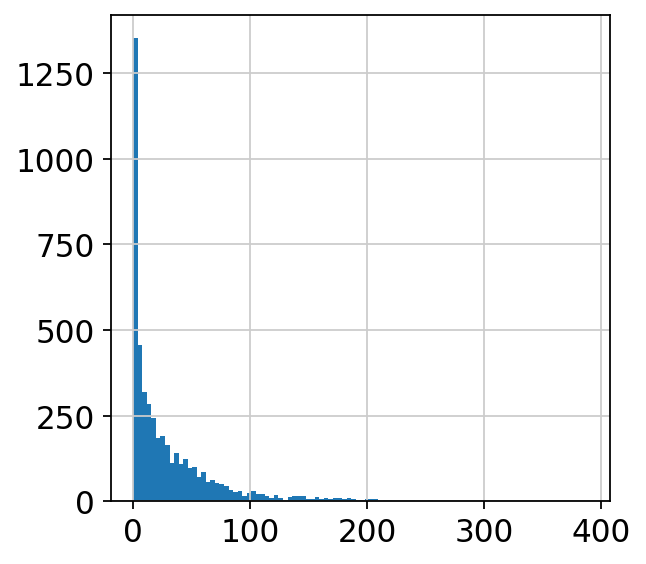

In [38]:
plt.hist(ct_df['NUM_CELLS'].values,bins=100);

In [39]:
ct_df.drop(columns=['NUM_CELLS'],inplace=True)

In [80]:
# AVOID RE-RUNNING THIS AGAIN
# ct_df.to_pickle(prefix + 'mrna/pkls/aggr/pseudobulk.cts.pkl')

# Pseudobulk Normalizing by Individual

In [108]:
def get_pseudobulk(adata, covars):
    assert covars[-1] == 'free_id'
    genes = adata.var_names.tolist()
    donors = np.unique(adata.obs['free_id'].tolist())
    pseudobulk = pd.DataFrame(index=genes, columns=donors)
    for i in range(len(donors)):
        fdata = adata[adata.obs['free_id'] == donors[i]]
        pseudobulk[donors[i]] = np.ravel(np.sum(fdata.X, axis=0)/np.sum(fdata.X))
    
    unique_rows = ~adata.obs[covars].duplicated()
    covar_df = adata.obs.loc[unique_rows, covars].set_index('free_id')
    pseudobulk.columns = pd.MultiIndex.from_frame(covar_df.loc[pseudobulk.columns].reset_index())
#     pseudobulk = pseudobulk.T.sort_values(covars[:-1])
#     pseudobulk.index = pseudobulk.index.reorder_levels(covars)
    return pseudobulk

In [109]:
covars = ['free_id']
mean_dfs = dict()

In [110]:
conds_1 = ['A', 'B', 'G', 'P', 'R']
cts_1 = ['B_Mem', 'B_Naive', 'T4_Mem', 'T4_Naive', 'T_Tox', 'T8_Naive', 'HSC', 'NK', 'pDC']

In [111]:
conds_2 = ['A', 'B', 'G', 'R']
cts_2 = ['cM', 'ncM', 'cDC']

In [120]:
ct_cond_combos = list(it.product(cts_1, conds_1)) + list(it.product(cts_2, conds_2))

In [114]:
for ct, cond in tqdm(ct_cond_combos):
    mean_dfs[(ct, cond)] = get_pseudobulk(raw_mrna[(raw_mrna.obs['ct2'] == ct) & (raw_mrna.obs['cond'] == cond)], covars)

mean_df_pseudo = get_pseudobulk(raw_mrna, covars)

In [115]:
mean_df_pseudo

index,0,1,10,11,12,13,14,15,16,17,...,58,59,6,60,61,62,63,7,8,9
AL627309.1,4.604985e-07,5.285489e-07,3.364103e-07,1.982033e-07,3.938347e-07,7.300201e-07,4.522583e-07,1.088048e-06,8.682588e-07,7.543632e-07,...,0.000000,5.620128e-07,8.434025e-08,2.365897e-07,6.374132e-07,1.087761e-06,6.178674e-07,5.394569e-07,3.662488e-07,3.638369e-07
AL627309.3,5.756232e-08,7.550698e-08,1.261539e-07,6.606778e-08,4.922934e-08,1.327309e-07,2.584333e-07,6.800298e-08,1.240370e-07,1.077662e-07,...,0.000000,0.000000e+00,8.434025e-08,1.577264e-07,1.274826e-07,3.107888e-07,1.235735e-07,5.394569e-08,0.000000e+00,4.547962e-08
AL669831.5,4.662548e-06,3.548828e-06,5.298462e-06,5.483626e-06,5.513687e-06,5.840161e-06,5.104058e-06,5.916259e-06,6.325886e-06,6.573736e-06,...,0.000008,4.496102e-06,4.385693e-06,4.022024e-06,4.971822e-06,2.952493e-06,7.290836e-06,6.095863e-06,4.639151e-06,3.911247e-06
LINC00115,2.935678e-06,3.020279e-06,2.901539e-06,2.510576e-06,3.642971e-06,2.853715e-06,4.134933e-06,4.080178e-06,2.976887e-06,3.448517e-06,...,0.000000,3.372077e-06,2.951909e-06,3.469982e-06,2.549653e-06,3.884860e-06,5.190086e-06,3.506470e-06,3.479364e-06,2.728777e-06
FAM41C,3.108365e-06,1.849921e-06,1.808205e-06,2.312372e-06,3.101449e-06,2.322791e-06,3.165808e-06,2.720119e-06,2.852850e-06,2.047557e-06,...,0.000000,5.058115e-06,3.626631e-06,2.523623e-06,3.314548e-06,3.107888e-06,4.077925e-06,1.888099e-06,1.831244e-06,2.137542e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC007325.4,7.483101e-07,6.795628e-07,7.148719e-07,7.267456e-07,4.922935e-07,6.636547e-07,5.814749e-07,6.800298e-07,1.116333e-06,8.621294e-07,...,0.000004,1.967045e-06,1.012083e-06,1.340675e-06,7.648958e-07,9.323663e-07,4.942939e-07,8.631310e-07,6.104147e-07,7.731535e-07
AL354822.1,4.086924e-06,3.171293e-06,2.775385e-06,2.180237e-06,1.083046e-06,1.327309e-06,5.556316e-06,1.292056e-06,6.201849e-06,9.698955e-07,...,0.000004,6.744153e-06,3.120589e-06,1.261812e-06,3.951961e-06,1.709338e-06,1.730029e-06,7.606342e-06,1.526037e-06,3.001655e-06
AC004556.1,3.453739e-07,4.152884e-07,4.625642e-07,7.267456e-07,4.607867e-05,3.318274e-07,3.876500e-07,2.053690e-05,1.897766e-05,8.621294e-07,...,0.000000,8.430192e-07,6.747220e-07,6.309058e-07,5.099305e-07,6.215776e-07,2.557971e-05,2.066120e-05,3.052074e-07,5.457554e-07
AC233755.1,0.000000e+00,7.550698e-08,0.000000e+00,0.000000e+00,2.953761e-07,3.981928e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,2.530207e-07,3.154529e-07,0.000000e+00,3.107888e-07,0.000000e+00,2.157828e-07,1.220829e-07,9.095923e-08


In [117]:
de = dict() # differential expression dictionary
for cond in conds_1:
    de[cond] = dict()
    
combos = it.product(conds_1, cts_1)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'mrna/deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

In [118]:
combos = it.product(conds_2, cts_2)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'mrna/deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

In [159]:
de_genes = dict() # make a dictionary

# num_top_genes_to_keep = 200
for ct, cond in ct_cond_combos: 
    try:
        de_genes[ct]
    except KeyError:
        de_genes[ct] = dict()

    df = de[cond][ct] # get the DE results
    df = df[(df['log2FoldChange'] > 1)]
    
    # extract out genes, add them to the dictionary as a list
    df_significant = df[(df['padj'] < 0.01)]
    de_genes[ct][cond] = df_significant.index

all_de_genes = list()
lengths = list()
for ct, cond in ct_cond_combos:
    de_genes_list = de_genes[ct][cond]
    length = len(de_genes_list)
    lengths.append(length)
#     print((ct, cond, length))
    all_de_genes.append(de_genes[ct][cond])

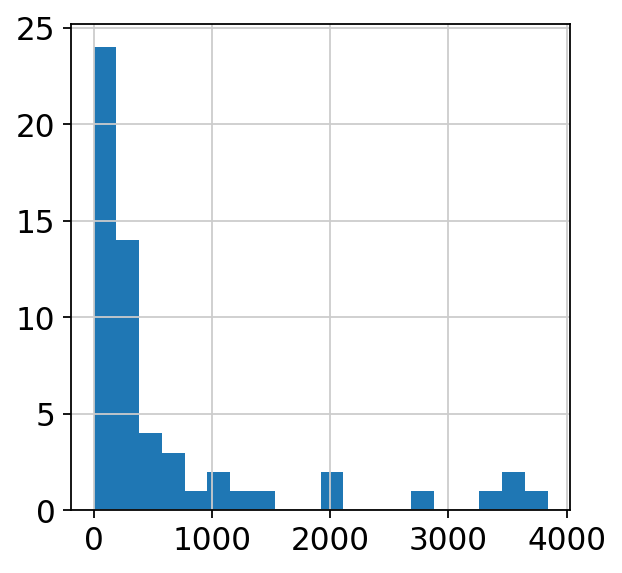

In [160]:
plt.hist(lengths, bins=20);

In [161]:
all_de_genes = np.unique([i for j in all_de_genes for i in j])

In [162]:
all_de_genes.shape

(7335,)

### Apply the Gene Filtration

Going to apply these to a new object called `heat_dfs`, that will eventually be used in the heatmap.

In [169]:
heat_dfs = dict()
for mean_df in tqdm(mean_dfs):
    heat_dfs[mean_df] = mean_dfs[mean_df].loc[all_de_genes].copy()
heat_df_pseudo = mean_df_pseudo.loc[all_de_genes].copy()

## Z Score the Values

Since we want to show the decreasing signals over time, we want to merge all the columns now and then z-score, instead of z-scoring each heatmap separately.

In [177]:
pd.concat([heat_dfs[heat_df].mean(1) for heat_df in ct_cond_combos], axis=1, keys=ct_cond_combos)

B_Mem                                           B_Naive            \
               A         B         G         P         R         A         B   
A1BG    0.000030  0.000016  0.000029  0.000014  0.000019  0.000038  0.000025   
AAED1   0.000055  0.000050  0.000039  0.000060  0.000047  0.000053  0.000057   
AAGAB   0.000028  0.000023  0.000032  0.000022  0.000028  0.000021  0.000023   
AAK1    0.000013  0.000012  0.000017  0.000025  0.000010  0.000019  0.000016   
AAMP    0.000052  0.000048  0.000051  0.000052  0.000040  0.000049  0.000051   
...          ...       ...       ...       ...       ...       ...       ...   
ZRANB3  0.000012  0.000008  0.000009  0.000005  0.000010  0.000006  0.000008   
ZSCAN2  0.000008  0.000005  0.000008  0.000021  0.000011  0.000005  0.000004   
ZSCAN9  0.000011  0.000008  0.000007  0.000007  0.000007  0.000010  0.000010   
ZSWIM6  0.000011  0.000012  0.000009  0.000014  0.000008  0.000014  0.000013   
ZUP1    0.000025  0.000028  0.000027  0.000033  0.000046  0.000024  0.000027   

                                      ...        cM                     ncM  \
               G         P         R  ...         G             R         A   
A1BG    0.000035  0.000030  0.000018  ...  0.000031  9.810979e-06  0.000042   
AAED1   0.000059  0.000069  0.000051  ...  0.000084  7.061045e-05  0.000115   
AAGAB   0.000027  0.000020  0.000028  ...  0.000010  7.251534e-06  0.000011   
AAK1    0.000019  0.000020  0.000012  ...  0.000048  4.126677e-05  0.000048   
AAMP    0.000051  0.000043  0.000051  ...  0.000069  2.186813e-05  0.000044   
...          ...       ...       ...  ...       ...           ...       ...   
ZRANB3  0.000006  0.000005  0.000012  ...  0.000002  6.331366e-07  0.000002   
ZSCAN2  0.000005  0.000002  0.000005  ...  0.000001  1.685305e-06  0.000001   
ZSCAN9  0.000008  0.000006  0.000008  ...  0.000004  2.072405e-06  0.000005   
ZSWIM6  0.000012  0.000013  0.000007  ...  0.000040  2.485917e-05  0.000026   
ZUP1    0.000026  0.000026  0.000047  ...  0.000016  1.138232e-05  0.000017   

                                               cDC                \
               B             G         R         A             B   
A1BG    0.000013  1.313810e-05  0.000009  0.000042  2.693245e-05   
AAED1   0.000152  1.278441e-04  0.000148  0.000057  1.136967e-04   
AAGAB   0.000012  1.284353e-05  0.000007  0.000011  8.320125e-06   
AAK1    0.000025  3.650879e-05  0.000022  0.000084  7.161351e-05   
AAMP    0.000041  7.766537e-05  0.000028  0.000032  3.458276e-05   
...          ...           ...       ...       ...           ...   
ZRANB3  0.000002  1.250454e-06  0.000001  0.000002  4.568483e-07   
ZSCAN2  0.000002  3.324611e-07  0.000004  0.000006  2.363769e-06   
ZSCAN9  0.000002  5.848652e-07  0.000004  0.000003  5.843161e-06   
ZSWIM6  0.000037  3.018043e-05  0.000011  0.000023  2.612374e-05   
ZUP1    0.000018  2.444676e-05  0.000017  0.000021  2.699810e-05   

                                    
                   G             R  
A1BG    3.386371e-05  1.796177e-05  
AAED1   6.339460e-05  8.245011e-05  
AAGAB   9.435723e-06  1.430504e-05  
AAK1    6.072597e-05  6.633098e-05  
AAMP    6.339743e-05  2.395265e-05  
...              ...           ...  
ZRANB3  8.519560e-07  2.013781e-07  
ZSCAN2  2.370884e-06  7.892379e-06  
ZSCAN9  6.823143e-06  2.056855e-06  
ZSWIM6  1.734782e-05  2.041786e-05  
ZUP1    2.868437e-05  2.808577e-05  

[7335 rows x 57 columns]

In [29]:
for ct in cts:
    heat_dfs[ct]['ct'] = ct
    heat_dfs[ct] = heat_dfs[ct].reset_index()
    heat_dfs[ct].index = pd.MultiIndex.from_frame(heat_dfs[ct][covars + ['ct']])
    heat_dfs[ct] = heat_dfs[ct].drop(columns=covars + ['ct'])

In [30]:
big_df = pd.concat([heat_dfs[ct].reset_index() for ct in heat_dfs])

In [31]:
big_df.shape

(792, 166)

In [32]:
random_ct = np.random.choice(cts) # doesn't matter which one, they're all the same, I just need to get the nlevels
big_df = pd.DataFrame(data=big_df.iloc[:,heat_dfs[random_ct].index.nlevels:].values, 
                      index=pd.MultiIndex.from_frame(big_df.iloc[:, :heat_dfs[random_ct].index.nlevels]),
                      columns=heat_dfs[random_ct].columns)

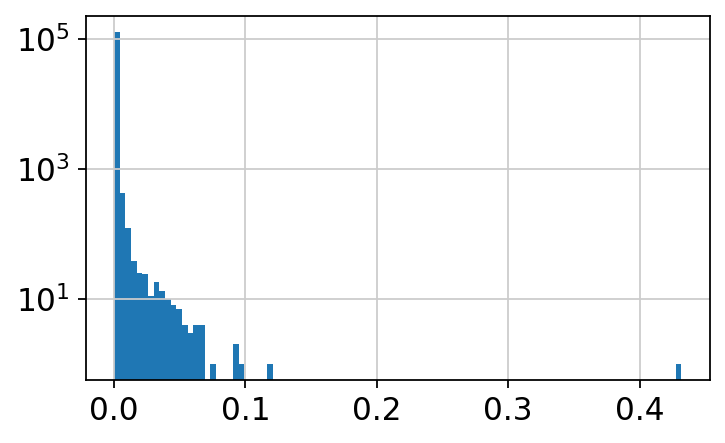

In [33]:
plt.figure(figsize=(5,3))
plt.hist(big_df.values.flatten(), bins=100);
plt.yscale('log')

In [34]:
def zscore(dataframe, axis=0):
    tmpl = pd.DataFrame(scipy.stats.zscore(dataframe, axis=axis), index=dataframe.index.tolist(), columns=dataframe.columns.tolist())
    return tmpl

In [35]:
big_df = zscore(big_df.T, axis=1).rolling(window=4, min_periods=1, axis=1).mean()
big_df = big_df.fillna(0)

In [36]:
heat_df_pseudo = zscore(heat_df_pseudo.T, axis=1).rolling(window=4, min_periods=1, axis=1).mean()
heat_df_pseudo = heat_df_pseudo.fillna(0)

Text(0, 0.5, 'density')

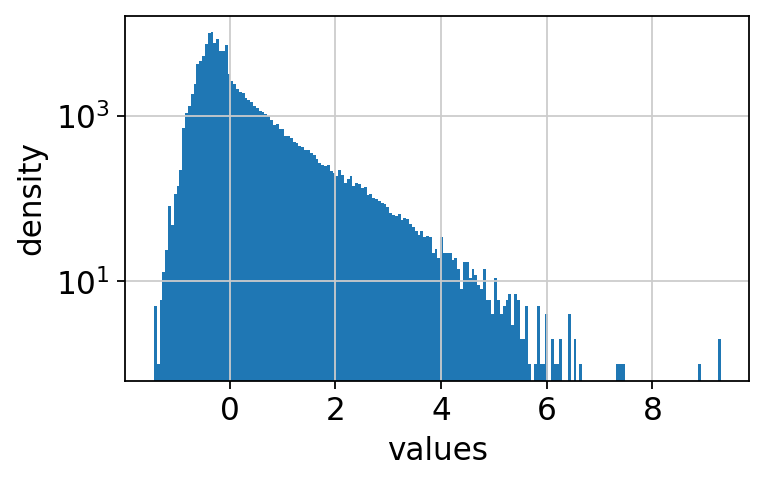

In [37]:
plt.figure(figsize=(5,3))
plt.hist(big_df.values.flatten(), bins=200);
plt.yscale('log')
plt.xlabel('values')
plt.ylabel('density')

In [38]:
(big_df.values.flatten() > 2).sum()/big_df.values.flatten().shape[0]

0.029997176736307172

index,0,1,10,11,12,13,14,15,16,17,...,57,59,6,60,61,62,63,7,8,9
A1BG,0.000020,0.000000,0.000059,0.000011,0.000057,0.000033,0.000018,0.000051,0.000037,0.000082,...,0.000014,0.000038,0.000019,0.000012,0.000067,0.000015,0.000028,0.000060,0.000020,0.000012
AAED1,0.000072,0.000067,0.000053,0.000067,0.000093,0.000085,0.000073,0.000102,0.000070,0.000082,...,0.000014,0.000077,0.000026,0.000050,0.000000,0.000060,0.000028,0.000026,0.000029,0.000081
AAGAB,0.000033,0.000025,0.000023,0.000022,0.000014,0.000007,0.000055,0.000014,0.000023,0.000041,...,0.000043,0.000013,0.000037,0.000012,0.000000,0.000015,0.000000,0.000034,0.000004,0.000035
AAK1,0.000007,0.000017,0.000029,0.000034,0.000050,0.000020,0.000018,0.000009,0.000010,0.000021,...,0.000014,0.000000,0.000022,0.000000,0.000000,0.000015,0.000000,0.000009,0.000016,0.000012
AAMP,0.000072,0.000059,0.000023,0.000056,0.000057,0.000059,0.000092,0.000065,0.000074,0.000021,...,0.000029,0.000038,0.000048,0.000025,0.000000,0.000119,0.000056,0.000051,0.000033,0.000035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZRANB3,0.000007,0.000008,0.000023,0.000011,0.000000,0.000013,0.000000,0.000005,0.000013,0.000041,...,0.000014,0.000013,0.000011,0.000012,0.000067,0.000015,0.000028,0.000009,0.000008,0.000006
ZSCAN2,0.000000,0.000004,0.000000,0.000011,0.000007,0.000020,0.000000,0.000009,0.000000,0.000021,...,0.000000,0.000026,0.000004,0.000012,0.000000,0.000030,0.000000,0.000009,0.000008,0.000000
ZSCAN9,0.000007,0.000017,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,0.000017,0.000000,...,0.000014,0.000013,0.000015,0.000000,0.000000,0.000000,0.000000,0.000009,0.000016,0.000012
ZSWIM6,0.000013,0.000013,0.000012,0.000000,0.000007,0.000026,0.000000,0.000018,0.000010,0.000000,...,0.000000,0.000000,0.000007,0.000025,0.000067,0.000030,0.000000,0.000009,0.000008,0.000000


In [28]:
for ct in heat_dfs:
    print(heat_dfs[ct].shape)
print(heat_df_pseudo.shape)

(76, 161)
(75, 161)
(66, 161)
(66, 161)
(76, 161)
(75, 161)
(73, 161)
(73, 161)
(76, 161)
(72, 161)
(64, 161)
(76, 161)
